[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Graf_et_al_2019/figure_4.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Graf_et_al_2019/figure_4.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Graf_et_al_2019/figure_4.ipynb)

based on [Graf et al. 2019](https://doi.org/10.5194/acp-19-747-2019)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [13]:
import math
import numpy as np
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si
from PySDM.environments import Parcel
from PySDM.backends import CPU
from PySDM import Builder, Formulae
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.initialisation.spectra import Lognormal
from PySDM.initialisation.sampling import spectral_sampling
from PySDM.initialisation import equilibrate_wet_radii, discretise_multiplicities
from PySDM import products

In [2]:
formulae = Formulae()
const = formulae.constants
pvs_water = formulae.saturation_vapour_pressure.pvs_water

RH0 = .75
p0 = 950 * si.hPa
T0 = const.T0 + 12 * si.K
alt_initial = 500 * si.m 
alt_final = 3500 * si.m

total_displacement = alt_final - alt_initial
initial_water_vapour_mixing_ratio = const.eps / (p0 / RH0 / pvs_water(T0) - 1)

n_sd = 1
dt = 10 * si.s
vertical_velocity = 2.5 * si.m / si.s

In [3]:
env = Parcel(
    # given in the paper
    p0=p0,
    T0=T0,
    initial_water_vapour_mixing_ratio=initial_water_vapour_mixing_ratio,
    # arbitrary choices
    w=vertical_velocity,
    dt=dt,
    mass_of_dry_air=1e3 * si.kg,
)

In [4]:
builder = Builder(backend=CPU(formulae=formulae), n_sd=n_sd, environment=env)
builder.add_dynamic(AmbientThermodynamics())
builder.add_dynamic(Condensation())

In [5]:
spectrum = Lognormal(norm_factor=1e4 / si.mg, m_mode=50 * si.nm, s_geom=1.5)
kappa = .5 * si.dimensionless
cloud_range = (.5 * si.um, 25 * si.um)
output_interval = 4
output_points = 40

In [6]:
r_dry, specific_concentration = spectral_sampling.Logarithmic(spectrum).sample(n_sd)

In [7]:
v_dry = formulae.trivia.volume(radius=r_dry)

In [8]:
r_wet = equilibrate_wet_radii(r_dry=r_dry, environment=builder.particulator.environment, kappa_times_dry_volume=kappa * v_dry)

In [9]:
attributes = {
    'multiplicity': discretise_multiplicities(specific_concentration * builder.particulator.environment.mass_of_dry_air),
    'dry volume': v_dry,
    'kappa times dry volume': kappa * v_dry,
    'volume': formulae.trivia.volume(radius=r_wet)
}

In [10]:
particulator = builder.build(
    attributes=attributes,
    products=(
        products.PeakSupersaturation(name='S_max'),
        products.ParcelDisplacement(name="z"),
        products.AmbientTemperature(name="T")
    )
)

In [11]:
n_steps = total_displacement / (dt * vertical_velocity)

output = {name:[] for name in particulator.products}
levels = {
    'CB': None,
    '0C': None
}

ONE_AND_ONLY_GRID_ELEMENT = 0

for step in range(math.ceil(n_steps)):
    particulator.run(steps=1)
    for name, product in particulator.products.items():
        product_buffer_reference = product.get()
        output[name].append(product_buffer_reference[ONE_AND_ONLY_GRID_ELEMENT])
      
    if levels['CB'] is None and output["S_max"][-1] > 0:
        levels['CB'] = .5 * (output["z"][-1] + output["z"][-2])
      
    if levels['0C'] is None and output["T"][-1] < const.T0:
        levels['0C'] = .5 * (output['z'][-1] + output["z"][-2])

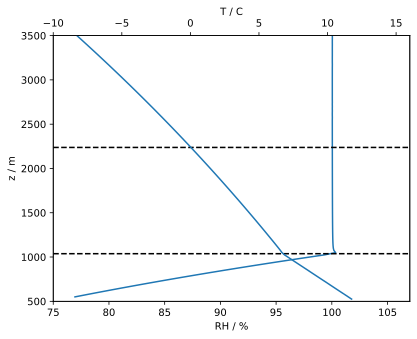

HTML(value="<a href='./fig_4a.pdf' target='_blank'>./fig_4a.pdf</a><br>")

In [12]:
from matplotlib import pyplot

fig, axs = pyplot.subplots(1, 1, squeeze=False)
xy1 = axs[0,0]
xy2 = xy1.twiny()

xy1.plot(
    (np.asarray(output['S_max']) + 1) * 100,
    np.asarray(output['z']) + alt_initial
)
xy2.plot(
    np.asarray(output['T']) - const.T0,
    np.asarray(output['z']) + alt_initial
)
for level in levels.values():
    xy1.axhline(y=level + alt_initial, linestyle='--', color='black')

xy1.set_xlim(75, 107)
xy2.set_xlim(-10, 16)
xy1.set_ylim(alt_initial, alt_final)
xy1.set_xlabel("RH / %")
xy2.set_xlabel("T / C")
xy1.set_ylabel("z / m")
show_plot('fig_4a.pdf')